In [69]:
import os
import re
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for classical machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Libraries for topic modeling
from pprint import pprint
import gensim
import spacy
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
import pyLDAvis.gensim

pd.set_option('display.max_colwidth', None)
%matplotlib inline

# lemmatize, 

### 1.0 Topic Modeling for Negative Sentiment

We will now use Gensim's LDA to identify the key pain points that dissatisfied customers are facing.

Before running LDA, we will first perform a simple pre-processing by removing stopwords, lemmatizing and using SpaCy to only keep tokens that are nouns, adjectives, verbs or adverbs. This approach gave us more distinct topics than if we were to just rely on the same pre-processing approach as that used during classification modeling.

In [15]:
# load datasets
reviews_train = pd.read_csv('../data/clean_train_stem.csv')
reviews_test = pd.read_csv('../data/clean_test_stem.csv')

reviews = pd.concat([reviews_test, reviews_train], ignore_index=True, axis=0)
reviews.head(3)

,content,content_stem,score,target
0,"I play on many different devices, and the game...",mani differ devic stay best downsid updat come...,5,0
1,Must to give 5 stars,must give star,5,0
2,The game is great but the developers do not ta...,develop feedback qualiti life ask pl add end c...,1,1


In [16]:
# Create a list of all the textual data from negative reviews
data = reviews[reviews['target']==1]['content'].values.tolist()

In [74]:
# Assign NLTK's stopwords to stop_words
stop_words = stopwords.words('english')

# stopwords_list = [
#     'character', 'characters', 'even', 'feel', 'fun', 'game', 'Genshin', 'genshin', 
#     'good', 'great', 'like', 'lot', 'love', 'make', 'much', 'need', 'play', 'player', 
#     'playing', 'played', 'really', 'still', 'story', 'take', 'want',
# ]

stopwords_list = [
    'game', 'Genshin', 'genshin',
    'play', 'player', 'playing', 'played',
    'much', 'make', 'really', 'even',
    'good', 'feel', 'get', 'great'
]

# Include frequently occuring words like 'app' and 'shopee' to the stopwords list. These words will not value add to our topics.
stop_words.extend(stopwords_list)

In [75]:
# Remove stopwords, lemmatize and only keep tokens that fall into these part of speech tags
def process_words(
        texts,
        stop_words=stop_words,
        allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    ) -> List[str]:
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # Lemmatize and only keep tokens that have certain part of speech tags
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    # Remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

# Pre-processing text
data_ready = process_words(data)

In [76]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready) 

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3, # Number of topics
    random_state=42,
    update_every=1,
    chunksize=10,
    passes=10,
    alpha='symmetric',
    iterations=100,
    per_word_topics=True
)

pprint(lda_model.print_topics())

[(0,
  '0.019*"phone" + 0.017*"mobile" + 0.016*"try" + 0.015*"fix" + '
  '0.015*"storage" + 0.014*"download" + 0.014*"update" + 0.014*"graphic" + '
  '0.012*"issue" + 0.012*"take"'),
 (1,
  '0.024*"character" + 0.019*"story" + 0.013*"time" + 0.011*"quest" + '
  '0.010*"system" + 0.009*"new" + 0.009*"reward" + 0.009*"bad" + 0.009*"year" '
  '+ 0.008*"event"'),
 (2,
  '0.056*"character" + 0.026*"culture" + 0.025*"people" + 0.023*"skin" + '
  '0.020*"natlan" + 0.019*"base" + 0.016*"design" + 0.012*"see" + 0.012*"dark" '
  '+ 0.011*"voice"')]


In [77]:
lda_model[corpus][0]

([(0, 0.15370022), (1, 0.8296095), (2, 0.016690295)],
 [(0, [1]),
  (1, [1, 0]),
  (2, [1]),
  (3, [1, 0]),
  (4, [1]),
  (5, [1]),
  (6, [0]),
  (7, [1]),
  (8, [1]),
  (9, [1, 0]),
  (10, [1]),
  (11, [1, 0]),
  (12, [1]),
  (13, [1]),
  (14, [1]),
  (15, [1]),
  (16, [1]),
  (17, [0]),
  (18, [1, 0]),
  (19, [1, 0])],
 [(0, [(1, 0.99987787)]),
  (1, [(0, 0.26220018), (1, 0.73303634)]),
  (2, [(1, 0.999864)]),
  (3, [(0, 0.2091105), (1, 0.65805125)]),
  (4, [(1, 0.99989116)]),
  (5, [(1, 0.9999343)]),
  (6, [(0, 0.99930096)]),
  (7, [(1, 0.9963998)]),
  (8, [(1, 0.99958646)]),
  (9, [(0, 0.062311564), (1, 0.9376488)]),
  (10, [(1, 0.99987286)]),
  (11, [(0, 0.06134725), (1, 0.9284463)]),
  (12, [(1, 0.99937737)]),
  (13, [(1, 0.99920946)]),
  (14, [(1, 0.9996106)]),
  (15, [(1, 0.99862754)]),
  (16, [(1, 0.99997216)]),
  (17, [(0, 0.9993415)]),
  (18, [(0, 0.23129323), (1, 0.7669539)]),
  (19, [(0, 0.040136274), (1, 0.9443002)])])

In [78]:
# Get main topic in each document
for i, row_list in enumerate(lda_model[corpus]):
    row = row_list[0] if lda_model.per_word_topics else row_list            
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    print(row)

    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => Dominant topic
            wp = lda_model.show_topic(topic_num)
            print(wp)

            topic_keywords = ", ".join([word for word, prop in wp])
            print([int(topic_num), round(prop_topic, 4), topic_keywords])
        else:
            break

    break

[(1, 0.8296098), (0, 0.15370014), (2, 0.016690088)]
[('character', 0.023991495), ('story', 0.019049471), ('time', 0.013314398), ('quest', 0.011494751), ('system', 0.010299429), ('new', 0.009132165), ('reward', 0.008947749), ('bad', 0.008813156), ('year', 0.008634412), ('event', 0.008224085)]
[1, 0.8296, 'character, story, time, quest, system, new, reward, bad, year, event']


In [79]:
def format_topics_sentences(ldamodel, corpus, texts) -> pd.DataFrame:
    """
    Formats the dominant topics for each document in a corpus along with their percentage contribution
    and associated keywords, returning a DataFrame with the results.

    ### Arguments:
    - ldamodel : `gensim.models.LdaModel`. The trained LDA model used to extract topics and keywords.
    - corpus : list of list of (int, int). The corpus used for LDA, typically a bag-of-words representation of the texts.
    - texts : list of str. The original documents corresponding to the corpus.

    ### Returns:
    A `pandas.DataFrame` containing the following columns:
    - 'Dominant_Topic': The most significant topic for each document.
    - 'Perc_Contribution': The percentage contribution of the dominant topic.
    - 'Topic_Keywords': The keywords associated with the dominant topic.
    - The original text of each document as an additional column.
    """
    # Init output
    sent_topics = []

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    sent_topics_df = pd.DataFrame(sent_topics, columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

In [80]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Formatting the table
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.8296,"character, story, time, quest, system, new, reward, bad, year, event","[developer, take, feedback, quality, life, ask, add, end, content, combat, simple, easy, challange, controller, support, story, extend, traversal, exploration, bad]"
1,1,0,0.5695,"phone, mobile, try, fix, storage, download, update, graphic, issue, take","[gameplay, also, graphic, want, say, unable, join, world, fix]"
2,2,0,0.8617,"phone, mobile, try, fix, storage, download, update, graphic, issue, take","[download, long, take, hour, delete, wanna, scaramouche, download, long, impatient, give, wait]"
3,3,1,0.9176,"character, story, time, quest, system, new, reward, bad, year, event","[repetitive, farming, artifact, suck, cause, hard, decent, piece, artifact, reward, pay, attention, anymore, reward, event, thing, ask, survey, hardly, listen, frustrating, tiring]"
4,4,2,0.6633,"character, culture, people, skin, natlan, base, design, see, dark, voice","[use, fun, truly, lack, representation, character, look, forward, sumeru, disappoint, look, natlan, character, honestly, surprise, anymore, still, love, time, time, truly, upset]"


In [81]:
# Keywords of each dominant topic
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic') 

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show the 3 topics
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9786,"phone, mobile, try, fix, storage, download, update, graphic, issue, take","[love, pc, reason, go, loading, point, pc, go, repair, phone, remain, option, leave, say, highly, annoying, first, time, actually, download, glitche, photo, gallery, several, download, past, point, fixing, issue, soon, possible, highly, appreciate]"
1,1,0.9838,"character, story, time, quest, system, new, reward, bad, year, event","[ruin, aspect, fall, catch, impossible, limited, time, event, require, certain, point, story, new, character, level, cap, access, new, area, material, think, return, remember, hour, storyline, side, quest, catch, back, new, need, month, grind, take, part, current, time, limit, never, return, event, break]"
2,2,0.9800,"character, culture, people, skin, natlan, base, design, see, dark, voice","[colorism, insane, tell, enemy, skin, color, diversity, range, light, dark, type, color, playable, character, dark, natlan, character, disappoint, poc, people, look, forward, dark, character, dark, skin, character, american, people, darker, skin, tone, hoyo, well]"


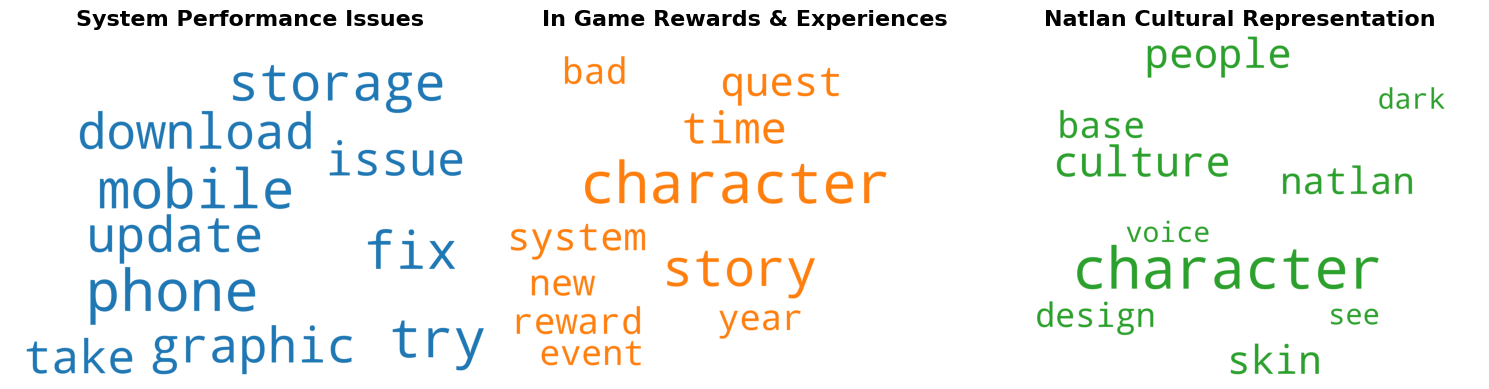

In [83]:
# Wordcloud of Top 10 words in each topic

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(15,10), sharex=True, sharey=True)

topic_names = ['System Performance Issues', 'In Game Rewards & Experiences', 'Natlan Cultural Representation']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], weight='bold', fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [84]:
# Visualisation of the topics estimated using LDA
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.035886 -0.240500       1        1  54.507760
0     -0.220920  0.147350       2        1  26.705822
2      0.256806  0.093151       3        1  18.786419, topic_info=          Term         Freq        Total Category  logprob  loglift
57   character  2415.000000  2415.000000  Default  30.0000  30.0000
357    culture   503.000000   503.000000  Default  29.0000  29.0000
96      people   470.000000   470.000000  Default  28.0000  28.0000
429       skin   438.000000   438.000000  Default  27.0000  27.0000
141      phone   515.000000   515.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
624      enemy   117.204454   199.772265   Topic3  -5.0967   1.1388
164        new   174.951079   731.513994   Topic3  -4.6961   0.2414
64        love   149.904728   497.812691   Topic3  -4.8506   0.4718
21         fix   133.009864   549.153435   Topic3  -4.9702   0.2541
135      issue   118.072379   476.461196   Topic3  -5.0893   0.2769

[164 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
897       2  0.988525     able
283       2  0.992391  account
0         1  0.997277      add
0         3  0.003227      add
20        1  0.759850     also
...     ...       ...      ...
154       2  0.996058     work
28        1  0.860163    world
28        3  0.138501    world
170       1  0.958910     year
170       3  0.039955     year

[188 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

We can conclude that the 3 topics are rather distinct as the bubbles are far away from one another on the intertopic distance map. The bar chart on the right represents the individual terms that are the most useful for interpreting a selected topic.

We will be browsing through some of the negative reviews in our dataset to better contextualise the 3 pain points that the LDA model has identified.

In [86]:
# Browse through the reviews that contain the top words related to each topic
reviews[(reviews['target']==1) & (reviews['content'].str.contains('Natlan|natlan'))]['content']

7                                                                                                                                                                                       This game used fo be really fun but it truly lack representation within its characters. I was really looking forward to Sumeru but was very disappointed. Now I looked at Natlan's characters and honestly I shouldn't be surprised anymore. I still love this game and will play it from time to time now but this truly upset me.
56      boring repetitive game with absolutely no diversity, just copy & paste characters with dif color hairs, their story quests are so borish that its hard to grow to like any of these characters. really long & boring quests with poor rewards. voice acting aint bad but paired with expressionless animations it's awful. let's not forget ripping inspro from real life places & not properly representing the people of said places like they did others. natlan is a disappointment and genshin 

In [87]:
# Browse through the reviews that contain the top words related to each topic
reviews[(reviews['target']==1) & (reviews['content'].str.contains('phone'))]['content']

18                                                   I have the specs that I need on my phone to play this game but it runs horribly. Constant frame rate drops game freezes and game crashes keep me from enjoying what would be an amazing experience. This game needs to be optimized better. I have it on the lowest possible graphic settings cleared out my phone cache boosted memory and got a game booster and nothing helps the issues I've been having. Gonna have to uninstall because it's unplayable.
31      but it should be more optimazed especialy at the ram and i mean by that is that the game should utilize more ram 4 the devices that have 12 or 16 gb or ram like for expl : my phone has 12 gb of ram and the system uses 6 gb of ram and when i play genshin the game only use 2-3 gb of ram making 3-4 gb of ram not in use now u might think that is positive but its the exact oppisite cuz the ram goes at hight speed wich makes the phone heat It can be fix eazlly by utilizing more ram if possble


### 2.0 Pain Points & Recommendations

##### **1. System Performance Issues**
- **Analysis:** Players are expressing concerns about technical issues, particularly with mobile devices. Keywords like "phone," "mobile," "storage," and "graphic" suggest performance problems such as lag, high storage requirements, or poor graphics optimization.
- **Recommendations:**
  - Optimize game performance for lower-end mobile devices by providing lightweight graphic settings and reducing storage requirements.
  - Communicate fixes or improvements in updates to reassure players.

##### **2. In-Game Rewards & Experiences**
- **Analysis:** Feedback highlights dissatisfaction with rewards, story pacing, and event systems. Keywords like "character," "story," "reward," and "quest" suggest that players find these elements lacking in engagement or value.
- **Recommendations:**
  - Enhance event rewards to offer more meaningful incentives.
  - Improve quest storytelling and event design to keep players engaged.
  - Introduce periodic feedback channels to understand what types of rewards or stories players prefer.

##### **3. Natlan Cultural Representation**
- **Analysis:** Players have high expectations for the representation of Natlan’s culture, evident from keywords like "culture," "character," "design," and "voice." Concerns may include authenticity and inclusivity in its portrayal.
- **Recommendations:**
  - Collaborate with cultural experts to ensure Natlan’s representation is respectful and immersive.
  - Involve the community through surveys or previews to gather feedback on character designs and lore.
  - Introduce culturally themed skins, music, or voice lines to enhance immersion.

By addressing these themes, Genshin Impact can improve player satisfaction and engagement, fostering a more positive community perception.